# Analysis of time-reversed model for oscillatory particle attraction
Tim Tyree<br>
12.13.2021

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from lib import *
from scipy.signal import savgol_filter
import dask.bag as db
from lib.lib_care.measure.bootstrap import bin_and_bootstrap_xy_values_parallel
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    
seed=42
np.random.seed(seed)

For the given phase, $\phi_0$, and for $t'=t_f-t$, the time-reversed problem is

$$
\frac{d\bar R}{dt'} = \frac{2a}{\bar R}\cos(\phi'-\omega t')
$$


We intend to study numerically the mean-squared range (MSR) versus the time leading up to annihilation in the presence of white-noise.  Our stochastic model is

$$
d\bar R = -\frac{2a}{\bar R}\cos(\omega t)dt + \sqrt{4D}dW
$$


# define module

In [2]:
# def gener_positions_oscillatory_reversed(
#     num_pairs=150, #number of independent pairs of particles
#     a=8.5, #cm^2/s known attraction coefficient 
#     D=0.3, #cm^2/s known diffusion coefficient
#     Dt=1e-5, #s
#     initial_phase_orientation=0.,#radians
#     period_of_oscillation=90.,#ms
#     rstart=1e-4,
#     rend=4, #cm
#     tmax=1,
#     printing=False,print_every=50000,
#     mode='oscillatory',
#     use_early_stopping=True,
#     **kwargs
#     ):
#     '''
#     Example Usage:
#     dict_out,positions_out=gener_positions_oscillatory_reversed(a=a,D=D,initial_phase_orientation=0.,printing=True)
#     '''
#     dont_break=True
#     #initialize particles locations as being at the same locations
#     t=0
#     x1=0
#     x2=np.sqrt(rstart)
#     y1=0
#     y2=np.sqrt(rstart)
#     zero_values=np.zeros(num_pairs)

#     x1_values=zero_values.copy()+x1
#     x2_values=zero_values.copy()+x2
#     y1_values=zero_values.copy()+y1
#     y2_values=zero_values.copy()+y2

#     stepscale = np.sqrt(2 * D * Dt)
#     impulse_prefactor = a * Dt

#     #tmax=1#10#0.1#1 #seconds
#     num_steps=np.int64(np.around(tmax/Dt))

#     position_array=np.zeros(shape=(num_steps,4,num_pairs))+np.nan
#     mean_array=np.zeros(shape=(num_steps,3))
#     std_array=np.zeros(shape=(num_steps,3))

#     #add support for still_running
#     boo_still_running=zero_values==zero_values

#     #compute the distance between each pair of particles
#     dx_values=(x2_values-x1_values)
#     dy_values=(y2_values-y1_values)
#     Rsq_values=dx_values*dx_values+dy_values*dy_values
#     omega=((1e-3*period_of_oscillation/(2*np.pi))**-1)
#     ##enforces the alignment boundary condition. smart, but might be messing up the oscillations
#     time_constant=initial_phase_orientation/omega
#     #time_constant=0.
#     if printing:
#         print(f"running simulation for {num_steps} steps...")
#     start=time.time()
#     step_num=0
#     while dont_break and (step_num < num_steps):
#         t=step_num*Dt + time_constant
#         #compute the attractive step between all pairs
#         f_values=impulse_prefactor/Rsq_values
#         F1x=f_values*dx_values
#         F1y=f_values*dy_values
#         if mode=='oscillatory':
#             F1x*=np.cos(omega*t)
#             F1y*=np.cos(omega*t)

#         #compute the diffusive step between all pairs
#         dxW1_values=stepscale*np.random.normal(size=num_pairs)
#         dxW2_values=stepscale*np.random.normal(size=num_pairs)
#         dyW1_values=stepscale*np.random.normal(size=num_pairs)
#         dyW2_values=stepscale*np.random.normal(size=num_pairs)

#         #the mean distance between all pairs of particles
#         R_values=np.sqrt(Rsq_values)
#         mean_R=np.mean(R_values)
#         std_R=np.std(R_values)

#         #the mean magnitude of the diffusive step
#         diffusive_step_values=0.5*np.sqrt(dxW1_values**2+dyW1_values**2)+0.5*np.sqrt(dxW2_values**2+dyW2_values**2)
#         mean_diffusive_step=np.mean(diffusive_step_values)
#         std_diffusive_step=np.std(diffusive_step_values)

#         #the mean magnitude of the attractive step
#         attractive_step_values=np.sqrt(F1x**2+F1y**2)
#         mean_attractive_step=np.mean(attractive_step_values)
#         std_attractive_step=np.std(attractive_step_values)
#         if printing:
#             if (step_num+1) % print_every == 0:
#                 relative_percent=100*mean_diffusive_step/mean_attractive_step
#                 print(f"simulation {100*(step_num+1)/num_steps:.0f}% completed: R={mean_R:.4f}+/-{1.96*std_R:.4f}, diffusion/attraction is {relative_percent:.2f}%")
#                 # print(f"the mean range is {mean_R:.4f} cm")
#                 # print(f"the mean diffusive step was {100*mean_diffusive_step/mean_attractive_step:.2f}% larger than the mean attractive step")

#         #compute the net change in position (with signs chosed s.t. repulsive at zero phase)
# #         x1step_values=F1x+dxW1_values
# #         y1step_values=F1y+dyW1_values
# #         x2step_values=-F1x+dxW2_values
# #         y2step_values=-F1y+dyW2_values
#         x1step_values=-F1x+dxW1_values
#         y1step_values=-F1y+dyW1_values
#         x2step_values=F1x+dxW2_values
#         y2step_values=F1y+dyW2_values

#         #identify any particles that didn't get within the threshold distance
#         #compute the distance between each pair of particles
#         dx_values=(x2_values-x1_values)
#         dy_values=(y2_values-y1_values)
#         Rsq_values=dx_values**2+dy_values**2

#         #update particle locations if they are still running
#         x1_values[boo_still_running]=x1_values[boo_still_running]+x1step_values[boo_still_running]
#         y1_values[boo_still_running]=y1_values[boo_still_running]+y1step_values[boo_still_running]
#         x2_values[boo_still_running]=x2_values[boo_still_running]+x2step_values[boo_still_running]
#         y2_values[boo_still_running]=y2_values[boo_still_running]+y2step_values[boo_still_running]
#         #DONE: verified the mean distance between particles got smaller    
#         # if (step_count+1) % save_every == 0:
#         #save particle locations to a numpy array with the correct number of positions
#         # x1,y1,x2,y2
#         position_array[step_num,0,boo_still_running]=x1_values[boo_still_running]
#         position_array[step_num,1,boo_still_running]=y1_values[boo_still_running]
#         position_array[step_num,2,boo_still_running]=x2_values[boo_still_running]
#         position_array[step_num,3,boo_still_running]=y2_values[boo_still_running]
#         mean_array[step_num,0]=mean_R
#         mean_array[step_num,1]=mean_diffusive_step
#         mean_array[step_num,2]=mean_attractive_step
#         #save results for quick plotting
#         std_array[step_num,0]=std_R
#         std_array[step_num,1]=std_diffusive_step
#         std_array[step_num,2]=std_attractive_step

#     #         #identify any particles that didn't get within the threshold distance
#     #         #compute the distance between each pair of particles
#     #         dx_values=(x2_values-x1_values)
#     #         dy_values=(y2_values-y1_values)
#     #         Rsq_values=dx_values*dx_values+dy_values*dy_values
#         R_values=np.sqrt(Rsq_values)
#         boo_still_running=boo_still_running&(R_values<rend)
        
#         step_num+=1
#         if use_early_stopping and not boo_still_running.any():
#             dont_break=False
#     if printing:
#         print(f"simulation complete!\nTotal run time: {time.time()-start:.4f} seconds")
#         print(f"the number of particles that didn't finished is {sum(boo_still_running)} out of {boo_still_running.shape[0]}.")

#     dict_out={
#         #         "Gamma_max":np.float32(Gamma_max),
#         #         "Gamma_values":Gamma_values.astype('float32'),
#         "Rsq_values":Rsq_values.astype('float32'),
#         "mean_array":mean_array.astype('float32'),
#         "std_array":std_array.astype('float32')
#     }
#     if printing:
#         print(*dict_out)
#         #print_dict(dict_out)
#     return dict_out,position_array#positions_out

In [3]:
# def visualize_model_oscillatory_reversed(ax=None,
#     a=1.6,#8.5,
#     D=0.6,#0.3,
#     initial_phase_orientation=np.pi,#0#np.pi/2,#-np.pi/2,
#     period_of_oscillation=45.,
#     num_pairs=1000,
#     rstart=1e-4,#1.5,
#     Dt=1e-5,
#     xmin=0,
#     xmax=0.1,
#     ymin=0,
#     ymax=0.6,
#     alpha=0.7,
#     show_inputted_a=True,show_title=True,show_legend=True,use_xylim=True,    
#     show_label_black_dotted=False,
#     printing=True,
#     plotting=True,c='C3',label=r"Simulation",**kwargs):
#     """generate MSR using the time-reversed oscillatory model. estimated run time is 15 seconds for 100 statistically independent trials.
#     Example Usage:
#     dict_fit=visualize_model_oscillatory_reversed(a=1.6,D=0.3,c='C0',label='Fenton-Karma')
#     dict_fit=visualize_model_oscillatory_reversed(a=8.5,D=0.6,c='C1',label='Luo-Rudy')
#     plt.show()
#     """
#     dict_out,position_array = gener_positions_oscillatory_reversed(
#                 a=a, D=D, printing=False,num_pairs=num_pairs,period_of_oscillation=period_of_oscillation,initial_phase_orientation=initial_phase_orientation,**kwargs)
#     positions_out=position_array
#     if printing:
#         print(*dict_out)
#         print(f"positions_out.shape={positions_out.shape}")

#     title=f"a={a:.1f}, D={D:.1f}, T={period_of_oscillation:.1f}, "+r"$\phi_f$"+f"={initial_phase_orientation:.4f}, "+r"R$_f$"+f"={rstart:.0e}, "+r" N$_{trials}$"+f"={num_pairs}\n"
    
#     #compute the distance between each pair of particles after aligning by annihilation (unshifted)
#     x1_values=positions_out[:,0]
#     y1_values=positions_out[:,1]
#     x2_values=positions_out[:,2]
#     y2_values=positions_out[:,3]
#     dx_values=(x2_values-x1_values)
#     dy_values=(y2_values-y1_values)
#     Rsq_values=dx_values**2+dy_values**2
#     #compute the ensemble averaged values
#     MSR_values=np.mean(Rsq_values,axis=1)
#     aligned_coordinates_values=np.mean(positions_out,axis=-1)
#     # maxt=Dt*MSR_values.shape[0]
#     t_values=np.arange(MSR_values.shape[0])*Dt
#     boo=~(np.isnan(t_values)|np.isnan(MSR_values))
#     dict_fit=compute_95CI_ols(t_values[boo],MSR_values[boo])
#     if printing:
#         print_dict(dict_fit)    
#         print(f"num_samples={positions_out.shape[-1]}")
#         print(f"num_timepoints={t_values.shape[0]}")
#         print(f"ahat = {dict_fit['m']/4:.4f}+/-{dict_fit['Delta_m']/4:.4f}")
    
#         if ax is None:
#             ax=plt.gca()
#         xv=np.linspace(xmin,xmax,100)
#         if show_inputted_a:
#             if show_label_black_dotted:
#                 ax.plot(xv,4*a*xv,'k--',label=r'$4a(t_f-t)$')
#             else:
#                 ax.plot(xv,4*a*xv,'k--')#,label=r'$4a(t_f-t)$')
#         if use_xylim:
#             ax.set_xlim([xmin,xmax])
#             ax.set_ylim([ymin,ymax])
#         ax.plot(t_values,MSR_values,c=c,label=label,alpha=alpha)
#         if show_title:
#             plt.title(title,fontsize=16)
#         if show_legend:
#             plt.legend(fontsize=16)
#         #plt.plot(t_values,t_values*0.,'--',c='gray',alpha=0.5)
#     #record
#     dict_fit['title']=title
#     dict_fit['tdeath']=t_values
#     dict_fit['MSR']=MSR_values
#     return dict_fit

# overlay the MSR of the full model over the MSR from the time-reversed oscillatory model

In [5]:
# # dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.6,c='C0',label='Fenton-Karma')
# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,c='C1',label='Luo-Rudy')
# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,1])
# plt.ylim([0,3])
# plt.show()
print(f"{1e-3:.0e}")

1e-03


In [6]:
#estimate a_sr expected for this value with a sliding window
msr_dir_lr=f'{nb_dir}/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# a_LR = 8.5950#+/-0.3771 cm^2/s
# tavg2=14 ms, num_samples=2083
msr_dir_fk=f'{nb_dir}/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# a_FK = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms
df_msd_lr=pd.read_csv(msr_dir_lr)
x_values_LR=df_msd_lr['tdeath_avg'].values
y_values_LR=df_msd_lr['MSR'].values
yerr_values_LR=df_msd_lr['Delta_MSR'].values
df_msd_fk=pd.read_csv(msr_dir_fk)
x_values_FK=df_msd_fk['tdeath_avg'].values
y_values_FK=df_msd_fk['MSR'].values
yerr_values_FK=df_msd_fk['Delta_MSR'].values

In [7]:
tmax=300#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_FK=a_SR

tmax=8#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
print('')
# tmax=8#ms #gives a nice value
tmax=90#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

tmax=8#ms #gives a nice value
# tmax=90#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

a_hat_FK = 1.604153+/-0.040173 cm^2/s, tmax=300
a_hat_FK = 7.392251+/-0.601845 cm^2/s, tmax=8

a_hat_LR = 2.245111+/-0.224026 cm^2/s, tmax=90
a_hat_LR = 8.595018+/-0.377114 cm^2/s, tmax=8


In [8]:
# a_osc_LR=8.5/4
# a_osc_FK=1.6
# D_osc_LR=3.#1.2
# D_osc_FK=1.6#.8
# a_osc_LR=8.5
# a_osc_FK=1.6
# D_osc_LR=0.6
# D_osc_FK=0.3
#worked pretty well
# a_osc_LR=8.5/2
# a_osc_FK=1.6
# D_osc_LR=1.2
# D_osc_FK=.9#.8
# #a=D test cases
# a_osc_LR=8./4
# a_osc_FK=6.4/4
# D_osc_LR=8./4
# D_osc_FK=6.4/4
# a_osc_LR=2.6#.2
# a_osc_FK=1.6#.4#.2#.6
# D_osc_LR=2.4#/2#.2
# D_osc_FK=1.6#.4#/2#.2#.6
#a=D/2 test cases
a_osc_LR=11./3#11.3/3
a_osc_FK=7.4/3
D_osc_LR=a_osc_LR/2
D_osc_FK=a_osc_FK/2

In [9]:
period_of_oscillation=120#ms
Rf=1e-2 #cm
omega=((1e-3*period_of_oscillation/(2*np.pi))**-1)
#enforces the alignment boundary condition. smart, but might be messing up the oscillations.  can be kept general if needed...
D=D_osc_FK;a=a_osc_FK
tf=Rf**2/(4*D);print(f"tf={tf}")
tf=Rf*np.arcsin(omega*Rf**2/(4*a));print(f"tf={tf}")
initial_phase_orientation=omega*tf
# initial_phase_orientation=omega*tf
initial_phase_orientation_FK=initial_phase_orientation#-np.pi/6,#-np.pi/4,#0,#np.pi/2,#radians
# initial_phase_orientation_FK+=np.pi/8
D=D_osc_LR;a=a_osc_LR
tf=Rf**2/(4*D);print(f"tf={tf}")
tf=Rf*np.arcsin(omega*Rf**2/(4*a));print(f"tf={tf}")
initial_phase_orientation=omega*tf
# initial_phase_orientation=omega*tf
initial_phase_orientation_LR=initial_phase_orientation
# initial_phase_orientation_LR+=np.pi/8

tf=2.027027027027027e-05
tf=5.30674459635687e-06
tf=1.3636363636363638e-05
tf=3.569991727638211e-06


Rsq_values mean_array std_array
positions_out.shape=(300000, 4, 1000)
m=10.14883431072985
Delta_m=0.0008363897877298296
b=-0.05304723884558449
Delta_b=0.0014486659856052925
Rsquared=0.9994698960348137
num_samples=1000
num_timepoints=300000
ahat = 2.5372+/-0.0002
Rsq_values mean_array std_array
positions_out.shape=(300000, 4, 1000)
m=15.017522155706134
Delta_m=0.0012394320046536457
b=-0.05076304511341334
Delta_b=0.0021467538376883028
Rsquared=0.9994683520868448
num_samples=1000
num_timepoints=300000
ahat = 3.7544+/-0.0003


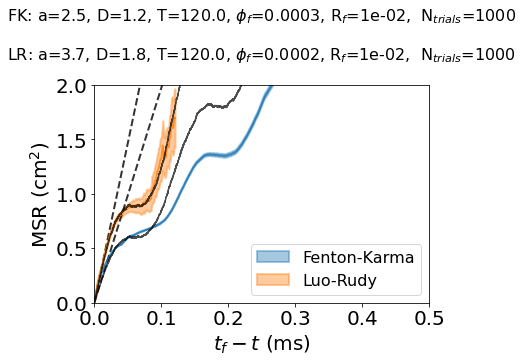

In [10]:
# Dscale=2
# tmax=0.1 #run time <10 seconds
tmax=3#1 #run time <2 minutes
# tmax=10 #run time >30 minutes...
#NOTE: if tmax=10 by necessity, and a grid search is desired for that, then a cupy acceleration of this routine may be warranted...
#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*(a_osc_LR+2*D_osc_LR)*xv,'--',lw=2,alpha=0.8,c='k')#C1')
plt.plot(xv,4*(a_osc_FK+2*D_osc_FK)*xv,'--',lw=2,alpha=0.8,c='k')#C0')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0',label='Fenton-Karma')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1',label='Luo-Rudy')

# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=1.2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6*2,D=1.2/2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=2.8,D=1.2/2,c='C0',label='Fenton-Karma')#too small of a_FK
# dict_fit_fk=visualize_model_oscillatory_reversed(a=4.,D=1.2/2,c='C0',label='Fenton-Karma')#osc. amplitude too big
# dict_fit_fk=visualize_model_oscillatory_reversed(a=a_osc_FK,D=.6*Dscale,
dict_fit_fk=visualize_model_oscillatory_reversed(a=a_osc_FK,D=D_osc_FK,
                                                 initial_phase_orientation=initial_phase_orientation_FK,#radians
                                                 period_of_oscillation=120,#ms
                                                 c='k',#'C0',
                                                 label='_',
                                                 show_title=False,tmax=tmax,show_inputted_a=False,rstart=Rf)

dict_fit_lr=visualize_model_oscillatory_reversed(a=a_osc_LR,D=D_osc_LR,
# dict_fit_lr=visualize_model_oscillatory_reversed(a=a_osc_LR,D=0.3*Dscale,
                                                 initial_phase_orientation=initial_phase_orientation_LR,#radians
                                                 period_of_oscillation=120,#ms
                                                 c='k',#'C1',
                                                 label='_',
                                                 show_title=False,tmax=tmax,show_inputted_a=False,rstart=Rf)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
title= "FK: "+dict_fit_fk['title']
title+= "\nLR: "+dict_fit_lr['title']
plt.title(title,fontsize=16)
plt.xlim([0,.5])
plt.ylim([0,2])
# plt.xlim([0,1])
# plt.ylim([0,3])
plt.legend(fontsize=16,loc='lower right')
# plt.show()

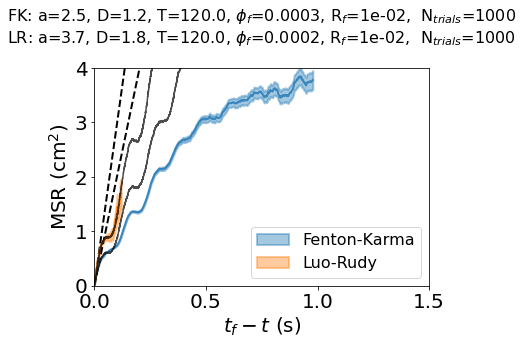

In [11]:
xv=np.linspace(0,1e3,200)
# a2=a_hat_LR
# a1=a_hat_FK
a2=a_osc_LR+2*D_osc_LR
a1=a_osc_FK+2*D_osc_FK
plt.plot(xv,4*a2*xv,'--',lw=2,alpha=1,c='k')
plt.plot(xv,4*a1*xv,'--',lw=2,alpha=1,c='k')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0',label='Fenton-Karma')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1',label='Luo-Rudy')

plt.plot(dict_fit_fk['tdeath'],dict_fit_fk['MSR'],'k',alpha=0.7)
plt.plot(dict_fit_lr['tdeath'],dict_fit_lr['MSR'],'k',alpha=0.7)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (s)',ylabel=r'MSR (cm$^2$)')
title= "FK: "+dict_fit_fk['title']
title+= "LR: "+dict_fit_lr['title']
plt.title(title,fontsize=16)
plt.xlim([0,1.5])
plt.ylim([0,4])
# plt.xlim([0,1])
# plt.ylim([0,3])
plt.legend(fontsize=16,loc='lower right')
plt.show()

- Question: does FK model diverge from 4a*tdeath for some tdeath<10 seconds?
- Answer: it doesn't appear so, 

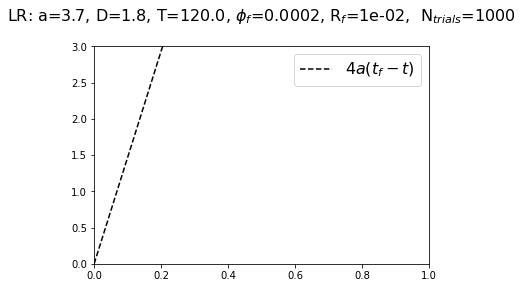

In [18]:
#TODO: plot ^those results zoomed out a bit
#FK values
ax=None
if ax is None:
    ax=plt.gca()
xmin=0
xmax=1
xv=np.linspace(xmin,xmax,100)
show_inputted_a=True
show_label_black_dotted=True
show_title=True
show_legend=True
if show_inputted_a:
    if show_label_black_dotted:
        ax.plot(xv,4*a*xv,'k--',label=r'$4a(t_f-t)$')
    else:
        ax.plot(xv,4*a*xv,'k--')#,label=r'$4a(t_f-t)$')

        
# ax.plot(t_values,MSR_values,c=c,label=label)
if show_title:
    plt.title(title,fontsize=16)
if show_legend:
    plt.legend(fontsize=16)

title= "FK: "+dict_fit_fk['title']
title= "LR: "+dict_fit_lr['title']
plt.title(title,fontsize=16)
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

# a number of token plots

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=6.466192670460866
Delta_m=0.0012711859255114307
b=-0.038307265382905076
Delta_b=0.0007339140318852725
Rsquared=0.9989950062563353
num_samples=1000
num_timepoints=100000
ahat = 1.6165+/-0.0003
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=9.786063100408553
Delta_m=0.00243670947524193
b=-0.030157441601460278
Delta_b=0.0014068243202019078
Rsquared=0.9983887225887894
num_samples=1000
num_timepoints=100000
ahat = 2.4465+/-0.0006


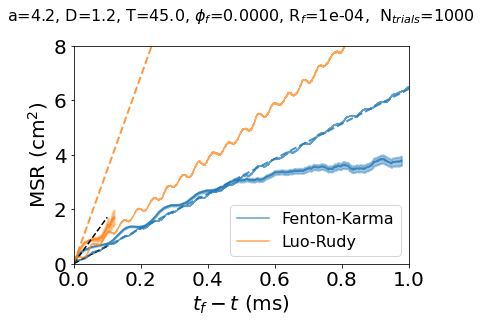

In [19]:
# initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
initial_phase_orientation=0.
# initial_phase_orientation=np.pi

#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')

# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=1.2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6*2,D=1.2/2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=2.8,D=1.2/2,c='C0',label='Fenton-Karma')#too small of a_FK
# dict_fit_fk=visualize_model_oscillatory_reversed(a=4.,D=1.2/2,c='C0',label='Fenton-Karma')#osc. amplitude too big
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.8,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')

dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5/2,D=1.2,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,8])
plt.show()

Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=6.46806040373298
Delta_m=0.001323194284297132
b=-0.026705048295446066
Delta_b=0.0007639408466274144
Rsquared=0.9989118082808559
num_samples=1000
num_timepoints=100000
ahat = 1.6170+/-0.0003
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=9.738092549516201
Delta_m=0.0026045695076141926
b=0.011251092455733414
Delta_b=0.0015037376282226486
Rsquared=0.9981413597778
num_samples=1000
num_timepoints=100000
ahat = 2.4345+/-0.0007


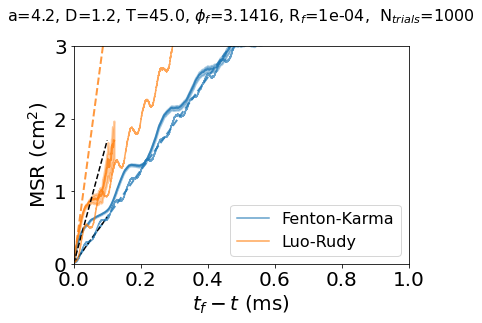

In [20]:
# initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
initial_phase_orientation=np.pi

#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')

# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=1.2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6*2,D=1.2/2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=2.8,D=1.2/2,c='C0',label='Fenton-Karma')#too small of a_FK
# dict_fit_fk=visualize_model_oscillatory_reversed(a=4.,D=1.2/2,c='C0',label='Fenton-Karma')#osc. amplitude too big
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.8,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5/2,D=1.2,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

In [ ]:
initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
# initial_phase_orientation=np.pi

#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')

# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=1.2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6*2,D=1.2/2,c='C0',label='Fenton-Karma')
# dict_fit_fk=visualize_model_oscillatory_reversed(a=2.8,D=1.2/2,c='C0',label='Fenton-Karma')#too small of a_FK
# dict_fit_fk=visualize_model_oscillatory_reversed(a=4.,D=1.2/2,c='C0',label='Fenton-Karma')#osc. amplitude too big
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.8,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')

dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5/2,D=1.2,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

In [ ]:
#plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.6,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,c='C1',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

# generate a figure panel showing the good agreement between the full models and the oscillatory model

In [86]:
# a_FK = 1.604153#+/-0.040173 cm^2/s, tmax=300
# a_LR = 2.245111#+/-0.224026 cm^2/s, tmax=90
# # a_hat_LR = 8.595018+/-0.377114 cm^2/s, tmax=8

# LR: z=2*pi*(15.5618+/- 1.867684 ms)/(120+/-20 ms)
# FK: z=2*pi*(197.3891+/- 35.600166 ms)/(110+/-10 ms)
G_over_T_LR=15.5618/120
G_over_T_FK=197.3891/110

In [92]:
print(f"for G_over_T_FK: {G_over_T_FK:.4f}")
print(f"for G_over_T_LR: {G_over_T_LR:.4f}")

# G_over_T=1/6
G_over_T=G_over_T_LR
z=2*np.pi*G_over_T
ahat_over_a=1+1/z+z/(1+z**2)
ahat_over_a_LR=ahat_over_a
# ahat_over_a_LR

# G_over_T=2
G_over_T=G_over_T_FK
z=2*np.pi*G_over_T
ahat_over_a=1+1/z+z/(1+z**2)
ahat_over_a_FK=ahat_over_a
# ahat_over_a_FK

a_LR = 3.535902#+/-0.312245 cm^2/s, tmax=60
a_FK = 1.604153#+/-0.040173 cm^2/s, tmax=300
ahat_expected_FK=ahat_over_a_FK*a_FK
ahat_expected_LR=ahat_over_a_LR*a_LR
print(f"ahat_expected_FK={ahat_expected_FK:.4f}")
print(f"ahat_expected_LR={ahat_expected_LR:.4f}")

for G_over_T_FK: 1.7944
for G_over_T_LR: 0.1297
ahat_expected_FK=1.8876
ahat_expected_LR=9.6069


Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=6.559644675650334
Delta_m=0.0012904502900606739
b=-0.00047680131902971823
Delta_b=0.0007450362345263649
Rsquared=0.998993615792245
num_samples=1000
num_timepoints=100000
ahat = 1.6399+/-0.0003
Rsq_values mean_array std_array
positions_out.shape=(100000, 4, 1000)
m=14.24733431611823
Delta_m=0.002790483859279
b=-0.07690465918701772
Delta_b=0.0016110745241694469
Rsquared=0.9990024434582504
num_samples=1000
num_timepoints=100000
ahat = 3.5618+/-0.0007


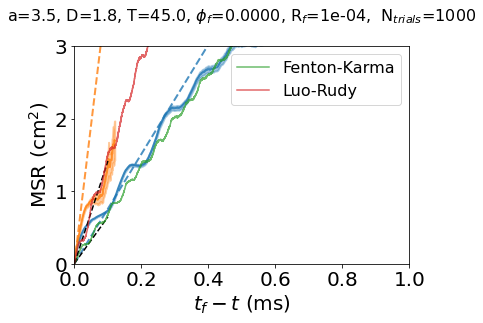

In [90]:
initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
# initial_phase_orientation=np.pi

#plot expected
fig,ax=plt.subplots(figsize=(6,4))
xv=np.linspace(0,1e3,200)
#plot the lines of effective attraction coefficient
# plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
# plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
plt.plot(xv,4*ahat_expected_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*ahat_expected_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot the full models
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
#plot the oscillatory particle model
dict_fit_fk=visualize_model_oscillatory_reversed(a=a_FK,D=a_FK/2,initial_phase_orientation=-np.pi/2,c='C2',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=a_LR,D=a_LR/2,initial_phase_orientation=0,c='C3',label='Luo-Rudy')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

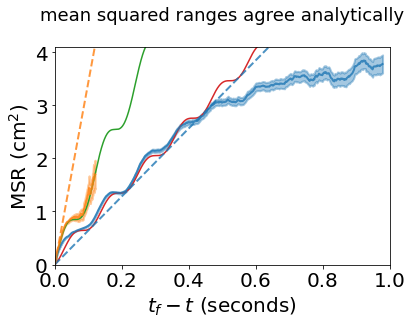

In [41]:
fig,ax=plt.subplots(figsize=(6,4))

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;
phi_f=0.;
# phi_f=-np.pi/2;
period=0.12 #s
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C2',
        label='$MSR_{Osc.} (a=a_{LR},\phi_f=0$)')
#         label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'$MSR_{Osc.} (a=a_{FK}, \phi_f=-\frac{\pi}{2})$')


xv=np.linspace(0,1,200)
#plot the lines of effective attraction coefficient
plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot the full models
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)')

plt.title('mean squared ranges agree analytically\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([0,4.1])
plt.show()

In [66]:
#compute the oscillatory particle model
kwargs_fk=dict(a=1.604153, D=1.604153/2, initial_phase_orientation=-np.pi/2, period_of_oscillation=110, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
# kwargs_lr=dict(a=3.535902, D=3.535902/2, initial_phase_orientation=-np.pi/2, period_of_oscillation=120, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
#                xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
kwargs_lr=dict(a=3.535902, D=3.535902/2, initial_phase_orientation=0, period_of_oscillation=120, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
dict_fit_fk=visualize_model_oscillatory_reversed(ax=ax,c='C0',label='Simulation of Osc. (FK)', **kwargs_fk)
dict_fit_lr=visualize_model_oscillatory_reversed(ax=ax,c='C1',label='Simulation of Osc. (LR)', **kwargs_lr)
plt.close()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


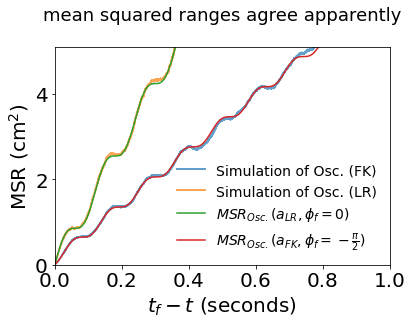

In [71]:
fig,ax=plt.subplots(figsize=(6,4))


#plot the oscillatory particle model
plt.plot(dict_fit_fk['tdeath'],dict_fit_fk['MSR'],lw=2,alpha=0.7,c='C0',label='Simulation of Osc. (FK)')
plt.plot(dict_fit_lr['tdeath'],dict_fit_lr['MSR'],lw=2,alpha=0.7,c='C1',label='Simulation of Osc. (LR)')

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;
phi_f=0.;
# phi_f=-np.pi/2;
period=0.12 #s
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C2',
        label=r'$MSR_{Osc.} (a_{LR}, \phi_f=0)$')
#         label=r'$MSR_{Osc.} (a_{LR}, \phi_f=-\frac{\pi}{2})$')
#         label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
D=a/2;
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'$MSR_{Osc.} (a_{FK}, \phi_f=-\frac{\pi}{2})$')

# #plot the full models
# plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
# plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
# plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
# plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

# #plot the lines of effective attraction coefficient
# xv=np.linspace(0,1,200)
# plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
# plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')

plt.legend(fontsize=14,frameon=False)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)')
plt.title('mean squared ranges agree apparently\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([0,5.1])
plt.show()

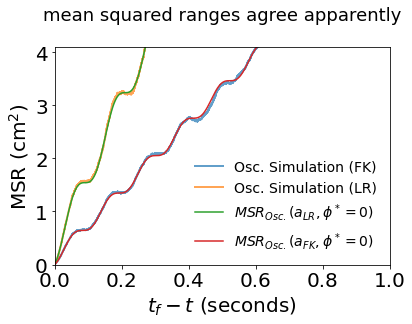

In [62]:
fig,ax=plt.subplots(figsize=(6,4))

#plot the oscillatory particle model
plt.plot(dict_fit_fk['tdeath'],dict_fit_fk['MSR'],lw=2,alpha=0.7,c='C0',label='Osc. Simulation (FK)')
plt.plot(dict_fit_lr['tdeath'],dict_fit_lr['MSR'],lw=2,alpha=0.7,c='C1',label='Osc. Simulation (LR)')

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;
# phi_f=0.;
phi_f=-np.pi/2;
period=0.12 #s
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C2',
        label=r'$MSR_{Osc.} (a_{LR},\phi^*=0)$')
#         label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
D=a/2;
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'$MSR_{Osc.} (a_{FK},\phi^*=0)$')

# #plot the full models
# plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
# plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
# plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
# plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

# #plot the lines of effective attraction coefficient
# xv=np.linspace(0,1,200)
# plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
# plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')

plt.legend(fontsize=14,frameon=False)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)')
plt.title('mean squared ranges agree apparently\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([0,4.1])
plt.show()

# generate a figure panel showing the good agreement between the oscillatory model and the analytic oscillatory model

In [93]:
#compute the oscillatory particle model
kwargs_fk=dict(a=1.604153, D=1.604153/2, initial_phase_orientation=-np.pi/2, period_of_oscillation=110, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
# kwargs_lr=dict(a=3.535902, D=3.535902/2, initial_phase_orientation=-np.pi/2, period_of_oscillation=120, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
#                xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
kwargs_lr=dict(a=3.535902, D=3.535902/2, initial_phase_orientation=0, period_of_oscillation=120, num_pairs=1000, rstart=0.0001, Dt=1e-05, 
               xmin=0, xmax=0.1, ymin=0, ymax=0.6, alpha=0.7, show_inputted_a=False, show_title=False, show_legend=True, use_xylim=True, show_label_black_dotted=False, printing=False, plotting=True)#, c='C3', label='Simulation')
dict_fit_fk=visualize_model_oscillatory_reversed(ax=ax,c='C0',label='Simulation of Osc. (FK)', **kwargs_fk)
dict_fit_lr=visualize_model_oscillatory_reversed(ax=ax,c='C1',label='Simulation of Osc. (LR)', **kwargs_lr)
plt.close()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


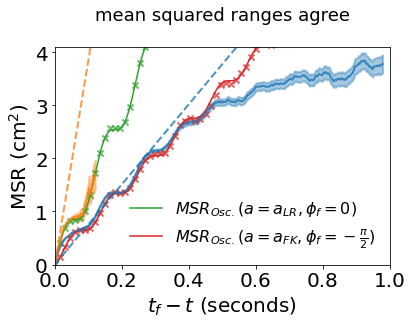

In [94]:
fig,ax=plt.subplots(figsize=(6,4))

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;
phi_f=0.;
# phi_f=-np.pi/2;
period=0.12 #s
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C2',
        label='$MSR_{Osc.}(a=a_{LR},\phi_f=0$)')
#         label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values,MSR_values_oscillatory,c='C3',
                label=r'$MSR_{Osc.}(a=a_{FK},\phi_f=-\frac{\pi}{2})$')


xv=np.linspace(0,1,200)
#plot the lines of effective attraction coefficient
#plot the lines of effective attraction coefficient
# plt.plot(xv,4*a_hat_LR*xv,'--',lw=2,alpha=0.8,c='C1')
# plt.plot(xv,4*a_hat_FK*xv,'--',lw=2,alpha=0.8,c='C0')
plt.plot(xv,4*ahat_expected_LR*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*ahat_expected_FK*xv,'--',lw=2,alpha=0.8,c='C0')
#plot the full models
plt.plot(x_values_FK*1e-3,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK*1e-3,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR*1e-3,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR*1e-3,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')


format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (seconds)',ylabel=r'MSR (cm$^2$)',fontsize=20)
plt.legend(fontsize=16,frameon=False)

#plot the oscillatory particle model
stepsize=1500
plt.scatter(dict_fit_fk['tdeath'][::stepsize],dict_fit_fk['MSR'][::stepsize],lw=2,alpha=.7,c='C3',marker='x')#,label='Simulation of Osc. (FK)')
plt.scatter(dict_fit_lr['tdeath'][::stepsize],dict_fit_lr['MSR'][::stepsize],lw=2,alpha=.7,c='C2',marker='x')#,label='Simulation of Osc. (LR)')

plt.title('mean squared ranges agree\n',fontsize=18)
plt.xlim([0,1])
plt.ylim([0,4.1])
plt.show()

In [95]:
1

1

# visualize a token individual trial from the time-reversed oscillatory model

In [ ]:
# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.6,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,c='C1',label='Luo-Rudy')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

In [ ]:
# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.3,c='C1',label='Luo-Rudy')
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.6,c='C0',label='Fenton-Karma',initial)
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,c='C1',label='Luo-Rudy')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1])
plt.ylim([0,3])
plt.show()

In [ ]:
dict_fit_fk=visualize_model_oscillatory_reversed(a=0.,D=0.6,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=0.,D=0.3,c='C1',label='Luo-Rudy')
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
# dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,c='C0',label='Fenton-Karma')
# dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,c='C1',label='Luo-Rudy')
# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
# plt.show()

In [ ]:
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,c='C1',label='Luo-Rudy')
plt.ylim((0,.05))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

# show MSR for four most-distant phases

In [ ]:
# initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.6,#0,#
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,#,0,#
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.ylim((0,4))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.6,#0,#
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,#,0,#
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.ylim((0,4))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.6,#0,#
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,#,0,#
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.ylim((0,4))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=.6,#0,#
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.6,#,0,#
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
plt.ylim((0,4))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
initial_phase_orientation=np.pi/2
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0,#.6,
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0,#0.3,
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.xlim(0,10)
plt.show()
#heretim

In [ ]:
# initial_phase_orientation=-np.pi/2
#initial_phase_orientation=np.pi/2
initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0,#0.6,
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0,#0.3,
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
# #initial_phase_orientation=np.pi/2
# # initial_phase_o|rientation=0.
initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0,#0.6,
                                                 show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0,#0.3,
                                                 show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

## repeat without diffusion

In [ ]:
# initial_phase_orientation=-np.pi/2
# #initial_phase_orientation=np.pi/2
initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
# #initial_phase_orientation=np.pi/2
initial_phase_orientation=0.
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

In [ ]:
# initial_phase_orientation=-np.pi/2
initial_phase_orientation=np.pi/2
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

In [ ]:
initial_phase_orientation=-np.pi/2
# initial_phase_orientation=np.pi/2
# initial_phase_orientation=np.pi
dict_fit_fk=visualize_model_oscillatory_reversed(a=1.6,D=0.,show_label_black_dotted=False,initial_phase_orientation=initial_phase_orientation,c='C0',label='Fenton-Karma')
dict_fit_lr=visualize_model_oscillatory_reversed(a=8.5,D=0.,show_label_black_dotted=True,initial_phase_orientation=initial_phase_orientation,c='C1',label='Luo-Rudy')
# plt.ylim((0,.2))
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
# plt.title(title,fontsize=16)
# plt.legend(fontsize=16)
plt.show()

# Visualize a number of trials, so as to paint a picture in terms of the full models

In [ ]:
1

In [ ]:
#estimated run time: 11 minutes
testing=True
if testing:
    #2 min. runtime
    a=8.5
    D=0.3
    num_pairs=400#2min 22sec: 100#1min 30sec: 10+1
    initial_phase_orientation=-np.pi/2
    #initial_phase_orientation=np.pi/2
    # initial_phase_orientation=np.pi
    #rstart=0.01#1.5,rstart=rstart
    #before, long runtime
    dict_out,position_array = gener_positions_oscillatory_reversed(
                a=a, D=D, printing=False,num_pairs=num_pairs,initial_phase_orientation=initial_phase_orientation)
    print(*dict_out)
    print(f"positions_out.shape={positions_out.shape}")
    beep(5)

In [ ]:
# positions_out=dict_out['positions_out']
Dt=1e-5
rstart=1e-4
title=f"a={a:.4f}, D={D:.4f},\n"+r"$\phi_0$"+f"={initial_phase_orientation:.4f}, "+r"R$_0$"+f"={rstart:.4f}, "+r" N$_{trials}$"+f"={num_pairs}\n"

print(f"positions_out.shape={positions_out.shape}")
#compute the distance between each pair of particles after aligning by annihilation (unshifted)
x1_values=positions_out[:,0]
y1_values=positions_out[:,1]
x2_values=positions_out[:,2]
y2_values=positions_out[:,3]
dx_values=(x2_values-x1_values)
dy_values=(y2_values-y1_values)
Rsq_values=dx_values**2+dy_values**2
#compute the ensemble averaged values
MSR_values=np.mean(Rsq_values,axis=1)
aligned_coordinates_values=np.mean(positions_out,axis=-1)
# maxt=Dt*MSR_values.shape[0]
t_values=np.arange(MSR_values.shape[0])*Dt
# x_values=aligned_mean_values[:,0]
# plt.plot(aligned_mean_values[:,1])
# plt.plot(aligned_mean_values[:,2])
# plt.plot(aligned_mean_values[:,3])

xmin,xmax=0,0.1
ymin,ymax=0,0.6
xv=np.linspace(xmin,xmax,100)
plt.plot(xv,4*a*xv,'k--',label=r'$4a(t_f-t)$')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(t_values,MSR_values,c='C5',label=r"Simulation")
# plt.plot(t_values,aligned_mean_values[::-1,0]**2)
plt.plot(t_values,t_values*0.,'--',c='gray',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (sec)',ylabel=r'MSR (cm$^2$)')
plt.title(title,fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [ ]:
boo=~(np.isnan(t_values)|np.isnan(MSR_values))
dict_fit=compute_95CI_ols(t_values[boo],MSR_values[boo])
print_dict(dict_fit)
print(f"num_samples={positions_out.shape[-1]}")
print(f"num_timepoints={t_values.shape[0]}")
print(f"ahat = {dict_fit['m']/4:.4f}+/-{dict_fit['Delta_m']/4:.4f}")

__Interacting Particle Models that could potentially explain the apparent disagreement for the Luo-Rudy model at long time scales__

Considering $C=\sqrt{4D}$,

$$
dR = \frac{-2a}{R}dt + CdW(t).
$$

The attracting inverse_powerlaw_model be changed to the fractional_powerlaw_model:

$$
dR = \frac{-2a}{R^b}dt + CdW(t)
$$

for $b=0.716(1)$ (LR) or $b=0.797(2)$ (FK).


The attracting inverse_powerlaw_model be changed to the attracting and repelling oscillatory_powerlaw_model:

$$
dR = \frac{-2a}{R}\cos(\omega t + \phi)dt + CdW(t)
$$

for $\omega=2\pi/T$ for $T=100$ ms (LR) or for $T=90$ ms (FK).  To keep the model simple, $\phi=\phi_0$ is a phase constant.